# Projet data - alternative au stage de fin de formation

## G-Research Crypto Forecasting

https://www.kaggle.com/c/g-research-crypto-forecasting

<img src="crypto.png"/>

### Modélisation et prédiction

**Important** : Executez le code de la partie 2 `crypto_preparation` avant de continuer.

In [1]:
import numpy as np
import pandas as pd
import pickle as pk
import matplotlib.pyplot as plt
import matplotlib.dates as md
import seaborn as sns
import datetime
import time
from sklearn.metrics import *
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
%matplotlib inline

In [10]:
def weighted_correlation(expected, predicted, weights):
    weights = np.ravel(weights)
    expected = np.ravel(expected)
    predicted = np.ravel(predicted)
    sum_weights = np.sum(weights)
    mean_expected = np.sum(expected * weights) / sum_weights
    mean_predicted = np.sum(predicted * weights) / sum_weights
    var_expected = np.sum(weights * np.square(expected - mean_expected)) / sum_weights
    var_predicted = np.sum(weights * np.square(predicted - mean_predicted)) / sum_weights
    cov = np.sum((expected * predicted * weights)) / np.sum(weights) - mean_expected * mean_predicted
    corr = cov / np.sqrt(var_expected * var_predicted)
    return corr

In [11]:
def load_data(filename):
    with open("./" + filename + ".pkl", 'rb') as f:
        objects = []
        unpickler = pk.Unpickler(f)
        while True:
            try:
                obj = unpickler.load()
                objects.append(obj)
            except:
                return tuple(objects)
    return tuple()

In [3]:
(df,) = load_data("crypto_df")
(d_assets_1_year,) = load_data("crypto_d_assets_1_year")
d_assets_1_year[0]["Asset_Data"].head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Upper_Shadow,Lower_Shadow,Log_Return_1min
timestamp,,,,,,,,,,,,
1600552800,0.0,319.0,27.3176,27.3346,27.2900,27.30840,3401.2153,27.317935,-0.002849,0.01700,0.0184,0.000020
1600552860,0.0,169.0,27.3080,27.3399,27.2958,27.32445,1756.3163,27.318485,-0.001419,0.01545,0.0122,0.000020
1600552920,0.0,170.0,27.3175,27.3367,27.2489,27.27730,1031.0570,27.293355,-0.000084,0.01920,0.0284,-0.000920
1600552980,0.0,153.0,27.2705,27.2810,27.2151,27.25110,1623.7244,27.270969,0.001622,0.01050,0.0360,-0.000821
1600553040,0.0,112.0,27.2333,27.2620,27.2106,27.25870,914.2690,27.231585,0.002324,0.00330,0.0227,-0.001445


#### Séparation en données de train et de test

Prenons une période de 4 mois pour le train et 1 mois pour le test.<br>
`train : du 01-02-2021 au 01-06-2021`<br>
`test : du 01-06-2021 au 01-07-2021`

In [4]:
def get_train_data(df):
    df["datetime"] = pd.to_datetime(df.index, unit='s')
    return df[(df["datetime"] >= '2021-02-01') & (df["datetime"] < '2021-06-01')]

In [5]:
def get_test_data(df):
    df["datetime"] = pd.to_datetime(df.index, unit='s')
    return df[(df["datetime"] >= '2021-06-01') & (df["datetime"] < '2021-07-01')]

In [6]:
df_bitcoin = d_assets_1_year[1]["Asset_Data"]
df_bitcoin_train = get_train_data(df_bitcoin)
df_bitcoin_test = get_test_data(df_bitcoin)
print("train:", df_bitcoin_train.iloc[0]["datetime"], "~", df_bitcoin_train.iloc[-1]["datetime"])
print("test:", df_bitcoin_test.iloc[0]["datetime"], "~", df_bitcoin_test.iloc[-1]["datetime"])

train: 2021-02-01 00:00:00 ~ 2021-05-31 23:59:00
test: 2021-06-01 00:00:00 ~ 2021-06-30 23:59:00


S'agissant d'un problème de regression, essayons et comparons les performances des modèles suivants :
- `LinearRegression`
- `CatBoostRegressor`
- `LGBMRegressor`
- `XGBRegressor`

In [100]:
MODELS = {
    "LinearRegression": { "type": LinearRegression, "params": { "n_jobs": -1 } },
    "CatBoostRegressor": { "type": CatBoostRegressor, "params": { "thread_count": -1, "verbose": 0 } },
    "LGBMRegressor": { "type": LGBMRegressor, "params": { "n_jobs": -1 } },
    "XGBRegressor": { "type": XGBRegressor, "params": { "n_jobs": -1 } },
}
FEATURES = [
    "Count",
    "Open",
    "High",
    "Low",
    "Close",
    "Volume",
    "VWAP",
    "Upper_Shadow",
    "Lower_Shadow",
    "Log_Return_1min",
]

In [101]:
def create_model(df_train, df_test, model_type):
    X_train = df_train[FEATURES]
    y_train = df_train["Target"]
    X_test = df_test[FEATURES]
    y_test = df_test["Target"]
    model = model_type["type"](**model_type["params"])
    model.fit(X_train, y_train)
    return { "X_train": X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test, "model": model }

#### Calcul de la corrélation pondérée pour chaque crypto-monnaie avec chaque modèle :

In [103]:
results = {}
for asset in d_assets_1_year.values():
    print(asset["Asset_Name"])
    df_train = get_train_data(asset["Asset_Data"])
    df_test = get_test_data(asset["Asset_Data"])
    results[asset["Asset_ID"]] = { "Asset_Name": asset["Asset_Name"] }
    for model_name, model in MODELS.items():
        reg_model = create_model(df_train, df_test, model)
        y_pred = reg_model["model"].predict(reg_model["X_test"])
        wcorr = weighted_correlation(reg_model["y_test"], y_pred, np.repeat(asset["Asset_Weight"], len(y_pred)))
        print("  %-18s: %f" % (model_name, wcorr))
        results[asset["Asset_ID"]][model_name] = {
            "model": reg_model["model"],
            "X_train": reg_model["X_train"],
            "X_test": reg_model["X_test"],
            "y_train": reg_model["y_train"],
            "y_test": reg_model["y_test"],
            "y_pred": y_pred,
            "weight": asset["Asset_Weight"],
            "wcorr": wcorr,
        }

Bitcoin Cash
  LinearRegression  : 0.017738


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

  CatBoostRegressor : 0.008592
  LGBMRegressor     : 0.014365
  XGBRegressor      : 0.019595
Binance Coin
  LinearRegression  : 0.019331
  CatBoostRegressor : 0.006961
  LGBMRegressor     : -0.001130
  XGBRegressor      : -0.004286
Bitcoin
  LinearRegression  : 0.015502
  CatBoostRegressor : -0.003719
  LGBMRegressor     : -0.018206
  XGBRegressor      : -0.008272
EOS.IO
  LinearRegression  : -0.005757
  CatBoostRegressor : 0.024542
  LGBMRegressor     : 0.028714
  XGBRegressor      : 0.026747
Ethereum Classic
  LinearRegression  : 0.004655
  CatBoostRegressor : 0.025875
  LGBMRegressor     : 0.010985
  XGBRegressor      : 0.032112
Ethereum
  LinearRegression  : -0.016576
  CatBoostRegressor : -0.008440
  LGBMRegressor     : -0.023333
  XGBRegressor      : -0.009080
Litecoin
  LinearRegression  : 0.030998
  CatBoostRegressor : 0.017015
  LGBMRegressor     : 0.022590
  XGBRegressor      : 0.022219
Monero
  LinearRegression  : -0.007975
  CatBoostRegressor : 0.015169
  LGBMRegressor     

#### Récupération du meilleur modèle pour chaque crypto-monnaie et affichage des résultats

In [107]:
for asset_id in results.keys():
    best_index = np.argmax([results[asset_id][model_name]["wcorr"] for model_name in MODELS.keys()])
    results[asset_id]["best_model"] = list(results[asset_id].keys())[best_index + 1]
    print("%-16s | %-18s| %f" % (results[asset_id]["Asset_Name"], results[asset_id]["best_model"], results[asset_id][results[asset_id]["best_model"]]["wcorr"]))

Bitcoin Cash     | XGBRegressor      | 0.019595
Binance Coin     | LinearRegression  | 0.019331
Bitcoin          | LinearRegression  | 0.015502
EOS.IO           | LGBMRegressor     | 0.028714
Ethereum Classic | XGBRegressor      | 0.032112
Ethereum         | CatBoostRegressor | -0.008440
Litecoin         | LinearRegression  | 0.030998
Monero           | CatBoostRegressor | 0.015169
TRON             | LinearRegression  | 0.087173
Stellar          | XGBRegressor      | 0.020934
Cardano          | LinearRegression  | 0.040639
IOTA             | XGBRegressor      | 0.002163
Maker            | LinearRegression  | 0.043932
Dogecoin         | LinearRegression  | 0.025617


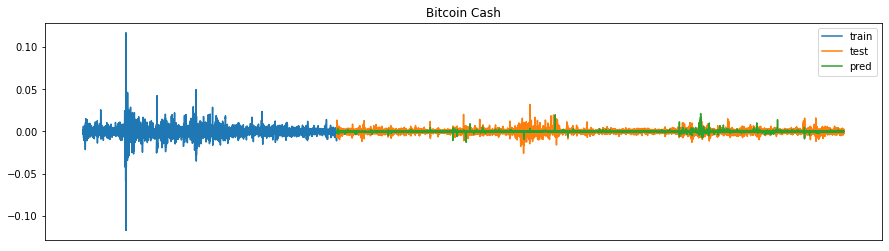

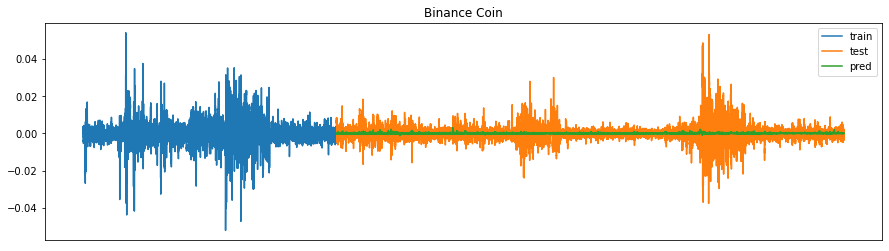

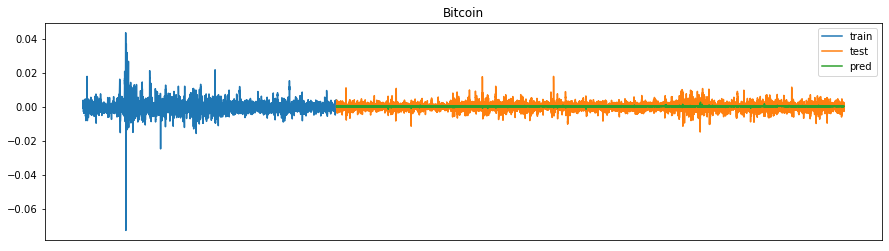

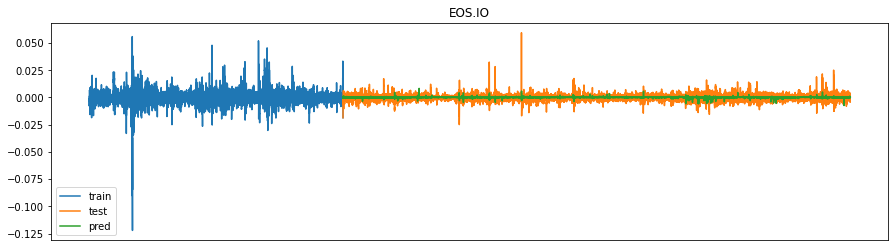

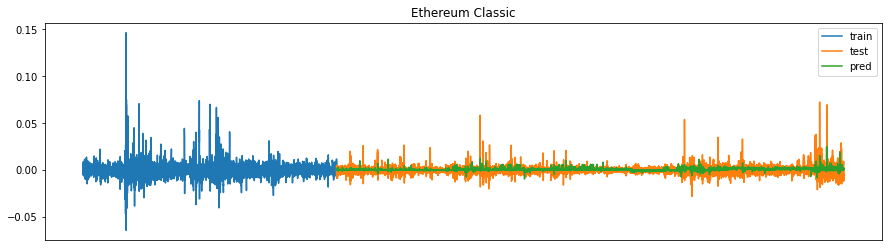

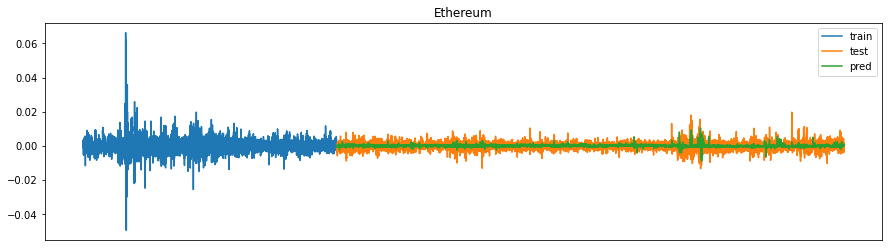

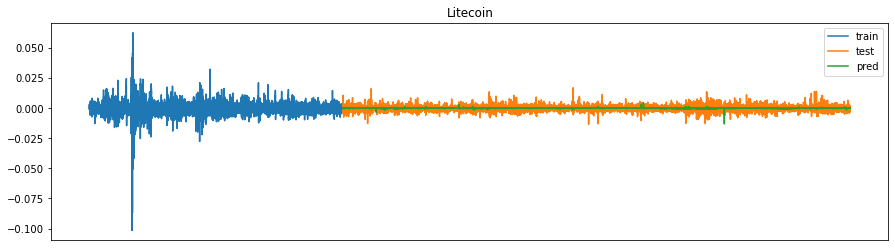

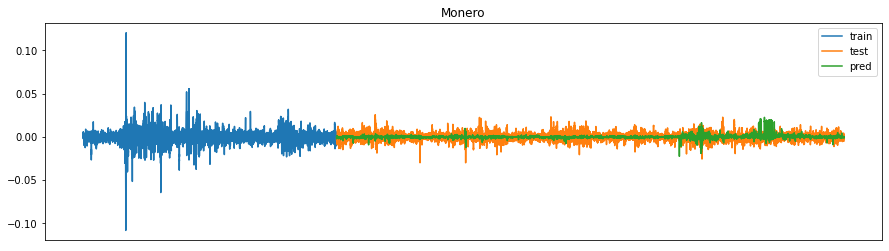

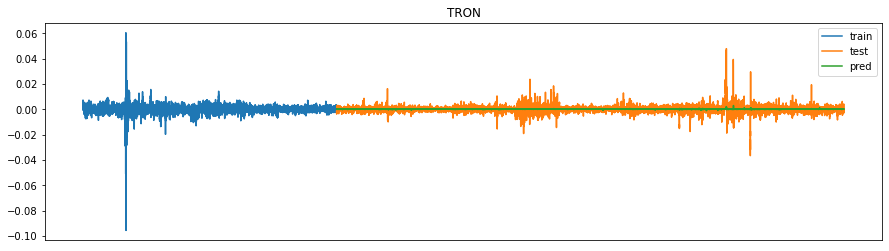

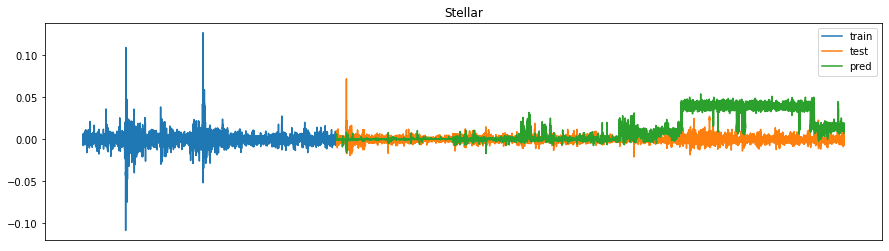

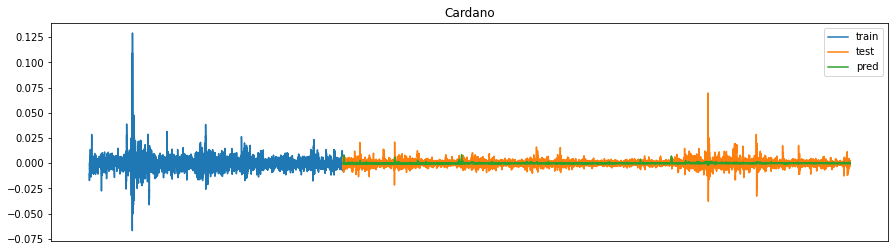

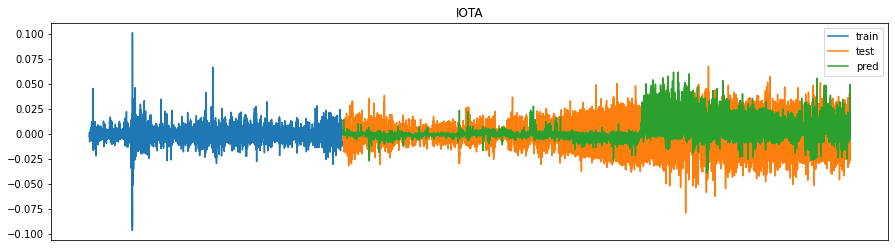

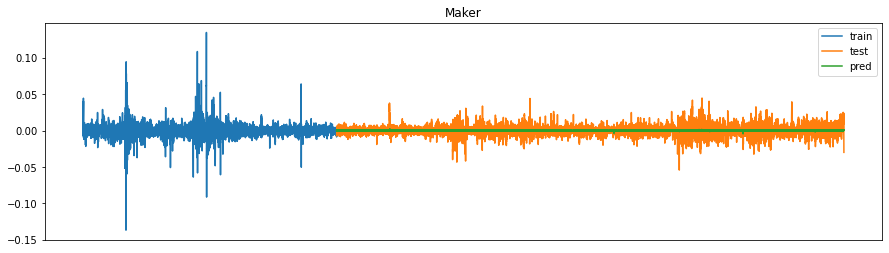

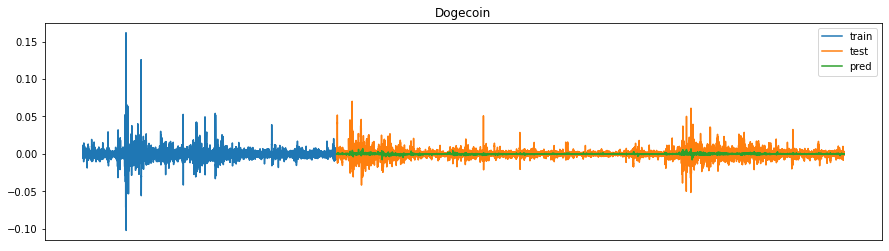

In [109]:
for asset_id in results.keys():
    model = results[asset_id][results[asset_id]["best_model"]]
    y_train = model["y_train"].copy()
    y_test = model["y_test"].copy()
    y_pred = pd.DataFrame(model["y_pred"], index=y_test.index)
    train_display_size = len(y_test) // 2
    plt.figure(figsize=(15, 4))
    plt.plot(y_train.iloc[-train_display_size:], label="train")
    plt.plot(y_test, label="test")
    plt.plot(y_pred, label="pred")
    plt.legend()
    plt.title(results[asset_id]["Asset_Name"])
    plt.xticks([])
    plt.show()

#### Soumission

In [127]:
# Unfortunately, the following doesn't work on Windows 10...
from ctypes import cdll
gresearch_crypto = cdll.LoadLibrary('./g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so')

OSError: [WinError 193] %1 n’est pas une application Win32 valide

In [128]:
def get_upper_shadow(row):
    return row.High - max(row.Open, row.Close)

def get_lower_shadow(row):
    return min(row.Open, row.Close) - row.Low

In [129]:
import gresearch_crypto
env = gresearch_crypto.make_env()
iter_test = env.iter_test()
for (df_test, sample_prediction_df) in iter_test:
    for i, row in df_test.iterrows():
        asset_id = row["Asset_ID"]
        model = results[asset_id][results[asset_id]["best_model"]]["model"]
        X_test = row.copy()
        X_test["Upper_Shadow"] = get_upper_shadow(row)
        X_test["Lower_Shadow"] = get_lower_shadow(row)
        X_test["Log_Return_1min"] = 0
        X_test = X_test[FEATURES]
        y_pred = model.predict(np.array([X_test]))[0]
        sample_prediction_df.loc[sample_prediction_df['row_id'] == row['row_id'], 'Target'] = y_pred
    env.predict(sample_prediction_df)

ModuleNotFoundError: No module named 'gresearch_crypto.competition'